# Computational topology - Sensors

You are given a number of points on the sphere of radius 1. You should view them as sensors on the surface of the Earth.  The sensors are used to gather data and form a sensor network with parameters $r$ and $R$:
- each sensor gathers data from the surrounding area in the shape of a circle of radius $R$,
- each sensor can communicate with other sensors which are at most $r$ away.

Project goal:  Determine $r$ and $R$, so that
1. numbers $r$ and $R$ are as small as possible (that would decrease the cost of sensors),
2. the sensor network is connected (i.e.  the Vietoris-Rips graph is connected),
3. the sensor network covers the whole sphere (the Čech complex should be homotopy equivalent to the sphere, i.e.  the Euler characteristic of the Čech complex should be that of a sphere).

Furthermore, once the parameters $r$ and $R$ are established, the program should return a list of obsolete sensors, i.e.  sensors, whose removal would not change the desired properties 2. and 3. of the sensor network.

**Data**: The input data is a set of points on the sphere of radius 1.

**Results**: The result should be required parameter values $r$ and $R$.
Start with an estimate for $r$ and $R$ and keep optimizing the values. To generate the Čech complex you can use the MiniBall algorithm.

**Data generator**: You should also produce a distribution of 50 points on the sphere with parameters $r$ and $R$ as small as possible.

In [1]:
%matplotlib widget

In [1]:
import miniball
from gudhi.alpha_complex import AlphaComplex
from gudhi.rips_complex import RipsComplex
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix
from scipy.optimize import minimize

from tools import *


plt.style.use('ggplot')

## The data

We were given $54$ points on a sphere.

In [2]:
with open('sensors.txt') as f:
    points = np.asarray([[float(p) for p in point.split(',')]
                         for point in f.read()[2:-3].split('},{')])
# print(points)

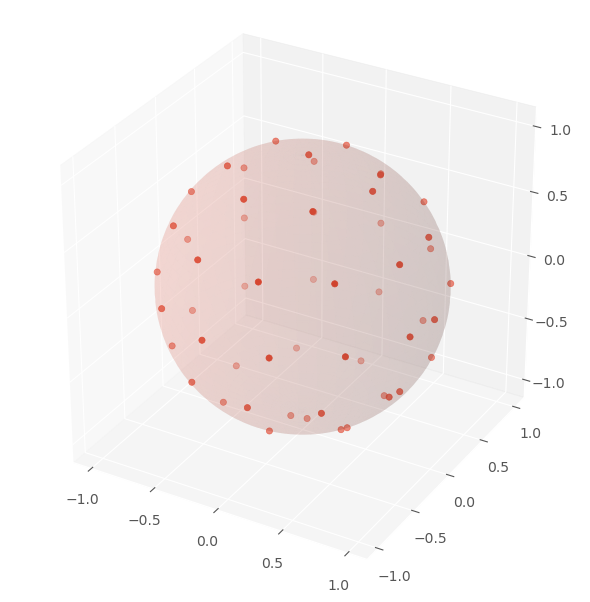

In [3]:
plot_sensors(points, fill=True)

## Computing $R$ (coverage radius)

To compute $R$, we considered:

### Spherical voronoi diagram

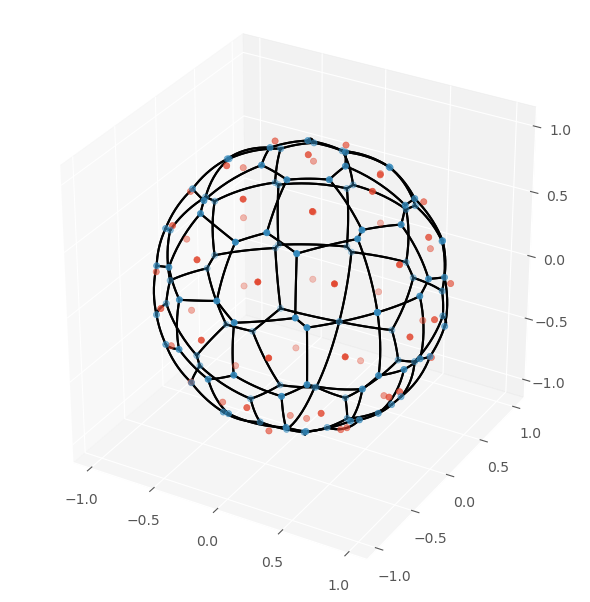

In [4]:
plot_sensors(points, voronoi=True, vertices=True, hull=False, fill=False)

In [5]:
def coverage_voronoi(points):
    sv = SphericalVoronoi(points)
    sv.sort_vertices_of_regions()
    R = max(distance_matrix(point[None, :], sv.vertices[region]).max()
            for point, region in zip(points, sv.regions))
    return R

print('Coverage radius:', coverage_voronoi(points))

Coverage radius: 0.36212076184477743


### Čech complex

To compute the Čech complex, we used the MiniBall algorithm. To use it, we first found all subsets of points (up to a given size).

In [6]:
def cech_complex(points, radius):
    """
    Compute the Čech complex.
    """
    simplices = []
    for subset in map(np.asarray, powerset(points)):
        _, r2 = miniball.get_bounding_ball(subset)
        if r2 <= radius ** 2:
            simplices.append(subset)
    return simplices

As this is very slow, we can precompute all relevant radii, and compute the complex using the stored values.

In [7]:
def miniball_radii(points, max_size=3):
    """
    Compute the miniball radii for all subsets of points 
    (within bounded dimensions).
    """
    radii = {}
    for subset in map(np.asarray, powerset(points, max_size=max_size)):
        _, r2 = miniball.get_bounding_ball(subset)
        radii[subset.tobytes()] = r2
    return radii

bounding_radii = miniball_radii(points, max_size=3)

Now, we can "quickly" compute Čech, check if it is connected and compute the Euler characteristic. The coverage radius is then found by performing two bisections.

In [8]:
def fast_cech_complex(points, radii, radius, max_size=3):
    """
    Compute the Čech complex.
    """
    simplices = []
    for subset in map(np.asarray, powerset(points, max_size=max_size)):
        if radii[subset.tobytes()] <= radius ** 2:
            simplices.append(subset)
    return simplices


def coverage_cech(points, radii, tolerance=1e-5, max_size=3):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left, right = 0, 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if connected(points, fast_cech_complex(points, radii, mid, max_size=max_size)):
            right = mid
        else:
            left = mid

    left = mid
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if euler(fast_cech_complex(points, radii, mid, max_size=max_size)) >= 2:
            right = mid
        else:
            left = mid

    return right

R = coverage_cech(points, bounding_radii)
cech_cx = fast_cech_complex(points, bounding_radii, R)
print('Coverage radius: ', R)
print('Simplex connected: ', connected(points, cech_cx))
print('Euler characteristic: ', euler(cech_cx))

Coverage radius:  0.3351093945093453
Simplex connected:  True
Euler characteristic:  2


In [9]:
# Just so we get a feeling for how the euler characteristic behaves.

for rad in np.linspace(0, 1, 20):
    print(f"E = {euler(fast_cech_complex(points, bounding_radii, rad)):5}, r = {rad}")

E =    54, r = 0.0
E =    52, r = 0.05263157894736842
E =    51, r = 0.10526315789473684
E =    49, r = 0.15789473684210525
E =    48, r = 0.21052631578947367
E =   -34, r = 0.2631578947368421
E =   -21, r = 0.3157894736842105
E =    39, r = 0.3684210526315789
E =    80, r = 0.42105263157894735
E =   162, r = 0.47368421052631576
E =   609, r = 0.5263157894736842
E =  1099, r = 0.5789473684210527
E =  1502, r = 0.631578947368421
E =  2349, r = 0.6842105263157894
E =  3865, r = 0.7368421052631579
E =  5200, r = 0.7894736842105263
E =  7227, r = 0.8421052631578947
E = 10681, r = 0.894736842105263
E = 14167, r = 0.9473684210526315
E = 23423, r = 1.0


### Alpha complex

As the Alpha complex is topologically equivalent to the Čech complex (at least if we trust the Gudhi documentation), we can compute it much faster, as it is part of the Gudhi library.

In [10]:
def coverage_alpha(points, tolerance=1e-16):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if connected_gudhi(points, AlphaComplex(points=points).create_simplex_tree(max_alpha_square=mid**2)):
            right = mid
        else:
            left = mid
    
    left = mid 
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if euler_gudhi(AlphaComplex(points=points).create_simplex_tree(max_alpha_square=mid**2)) >= 2:
            right = mid
        else:
            left = mid

    return right

R = coverage_alpha(points)
alpha_cx = AlphaComplex(points=points)
sx_tree = alpha_cx.create_simplex_tree(max_alpha_square=R**2)
print('Coverage radius: ', R)
print('Simplex connected: ', connected_gudhi(points, sx_tree))
print('Euler characteristic: ', euler_gudhi(sx_tree))

Coverage radius:  0.35613484552110825
Simplex connected:  True
Euler characteristic:  2


## Computing $r$ (connectivity radius)

To compute $r$, we considered:

### Vietoris-Rips complex

Using bisection, we can find the radius at which the complex connects.

In [11]:
def connectivity_rips(points, tolerance=1e-16):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if connected_gudhi(points, RipsComplex(points=points, max_edge_length=mid).create_simplex_tree(max_dimension=1)):
            right = mid
        else:
            left = mid
    return right

r = connectivity_rips(points)
rips_cx = RipsComplex(points=points, max_edge_length=R)
sx_tree = rips_cx.create_simplex_tree(max_dimension=1)
print('Connectivity radius: ', r)
print('Simplex connected: ', connected_gudhi(points, sx_tree))

Connectivity radius:  0.49650333792630236
Simplex connected:  False


### Persistence diagrams

We can build a persistence diagram of the Vietoris-Rips complex, and read at which radius it connects from there.

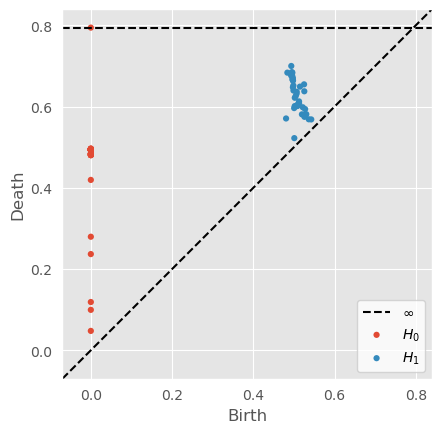

In [12]:
plot_diagrams(ripser(points, maxdim=1)['dgms'])
plt.show()

In [12]:
def connectivity_persistance(points):
    diagram = ripser(points)['dgms'][0]
    return diagram[diagram[:, 1] < float('inf')].max()

print('Connectivity radius: ', connectivity_persistance(points))

Connectivity radius:  0.4965033233165741


## Computing the radii

In [13]:
def compute_radii(points, coverage='voronoi', connectivity='persistence'):
    match coverage:
        case 'voronoi':
            R = coverage_voronoi(points)
        case 'cech':
            R = coverage_cech(points, bounding_radii)
        case 'alpha':
            R = coverage_alpha(points)
        case _:
            raise ValueError('coverage must be one of "voronoi", "cech" or "alpha"')

    match connectivity:
        case 'persistence':
            r = connectivity_persistance(points)
        case 'bisect':
            r = connectivity_rips(points)
        case _:
            raise ValueError('connectivity must be one of "persistence" or "bisect"')

    return R, r

In [14]:
compute_radii(points, coverage='voronoi', connectivity='persistence')

(0.36212076184477743, 0.4965033233165741)

In [15]:
compute_radii(points, coverage='cech', connectivity='bisect')

(0.3351093945093453, 0.49650333792630236)

In [16]:
compute_radii(points, coverage='alpha', connectivity='bisect')

(0.35613484552110825, 0.49650333792630236)

## Finding obsolete points

To find unecessary points, we can compute the radii and then check if we get the same (or very similar) radii when one of the points is not included.

In [17]:
def find_obsolete(points, coverage='voronoi', connectivity='persistence'):
    R, r = compute_radii(points, coverage=coverage, connectivity=connectivity)
    obsolete = []
    for i in range(len(points)-1):
        points_without = np.delete(points, i, axis=0)
        drop_R, drop_r = compute_radii(points_without, coverage=coverage, connectivity=connectivity)
        # if R_without <= R and r_without <= r:
        if np.allclose([drop_R, drop_r], [R, r]):
            obsolete.append(i)
    n = len(obsolete)
    if n > 1:
        obsolete_combinations = []
        for comb in chain.from_iterable(combinations(obsolete, i + 1) for i in range(n)):
            points_without = np.delete(points, comb, axis=0)
            R_without, r_without = compute_radii(points_without, coverage=coverage, connectivity=connectivity)
            if np.allclose([R_without, r_without], [R, r]):
                obsolete_combinations.append(comb)
        obsolete += obsolete_combinations
    return obsolete

In [18]:
indices = find_obsolete(points, coverage='voronoi', connectivity='persistence')
for ind, point in zip(indices, points[indices]):
    print(ind, point)

2 [ 0.49942  -0.26344  -0.825336]


Once the obsolete points are found, we can plot them.

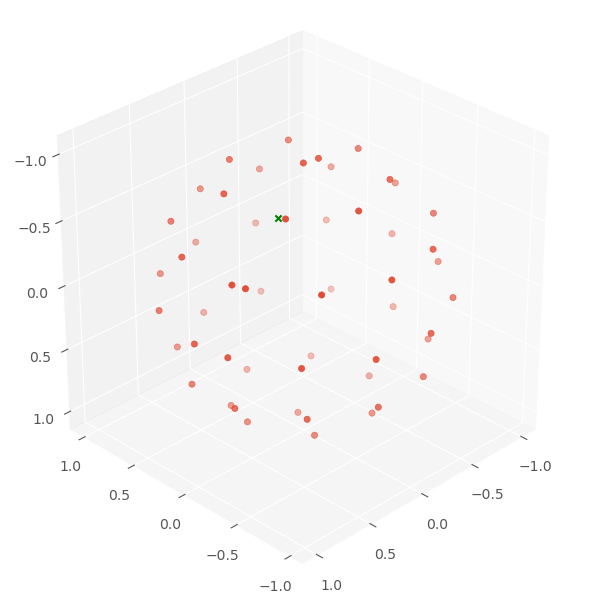

In [19]:
plot_sensors(points, obsolete=indices, rotation=(210, 135))

## Point generation

The first idea was to use a Fibonacci lattice to generate points on the sphere.

In [20]:
def generate_random(n, dim=3):
    v = np.random.randn(n, dim)
    v /= np.linalg.norm(v, axis=1)[:, None]
    return v


def generate_fibonacci(samples=50):
    z = np.linspace(-1, 1, samples)
    r = np.sqrt(1 - z**2)
    phi = np.pi * (np.sqrt(5.) - 1.) * np.arange(samples)
    x = np.cos(phi) * r
    y = np.sin(phi) * r
    return np.c_[x, y, z]

(0.6407349942217987, 0.6429962515830994)


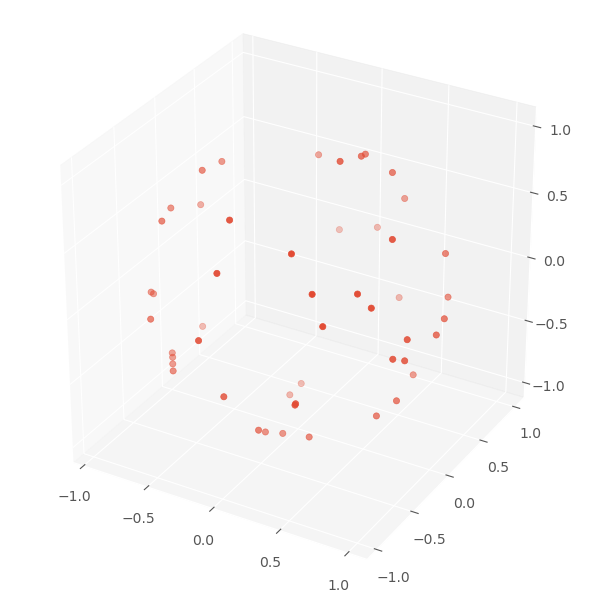

In [22]:
points = generate_random(50)
print(compute_radii(points))
plot_sensors(points)

(0.383517604532742, 0.4985489845275879)


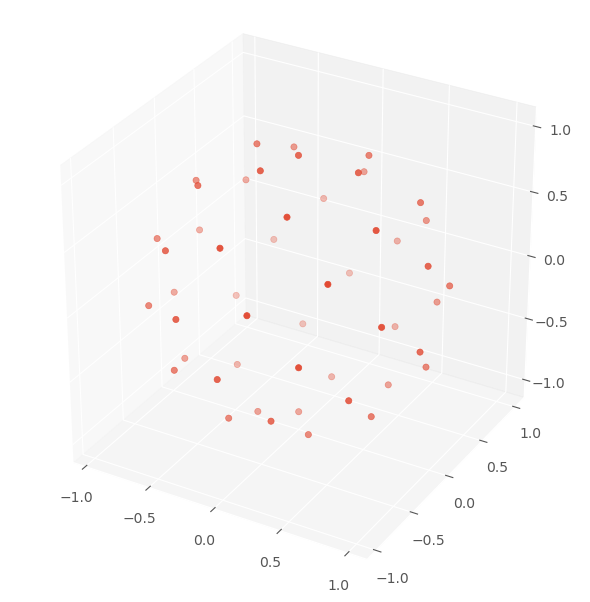

In [24]:
points = generate_fibonacci(50)
print(compute_radii(points))
plot_sensors(points)

### Point Optimisation

This point distribution can further be optimized by using the idea of minimizing potential.

In [25]:
def potential(points, dim=3):
    points = points.reshape(-1, dim)
    points /= np.linalg.norm(points, axis=1)[:, None]
    dm = np.triu(distance_matrix(points, points))
    return np.sum(dm[dm > 0] ** -2)


def radii(points, dim=3):
    points = points.reshape(-1, dim)
    points /= np.linalg.norm(points, axis=1)[:, None]
    return coverage_voronoi(points)


def constrain(points, dim=3):
    return sum(np.abs(np.linalg.norm(points.reshape(-1, dim), axis=1) - 1))

In [26]:
res = minimize(potential,
               points.reshape(-1),
               bounds=[(-1, 1)] * points.size,
               constraints={'type': 'eq', 'fun': constrain},
               method='SLSQP',
               options={'disp': True, 'maxiter': 1000})

out = res.x.reshape(-1, 3)
norm = np.linalg.norm(out, axis=1)[:, None]
out = out / norm

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1119.5995065316238
            Iterations: 323
            Function evaluations: 49452
            Gradient evaluations: 323


(0.3238121555401959, 0.5450849533081055)


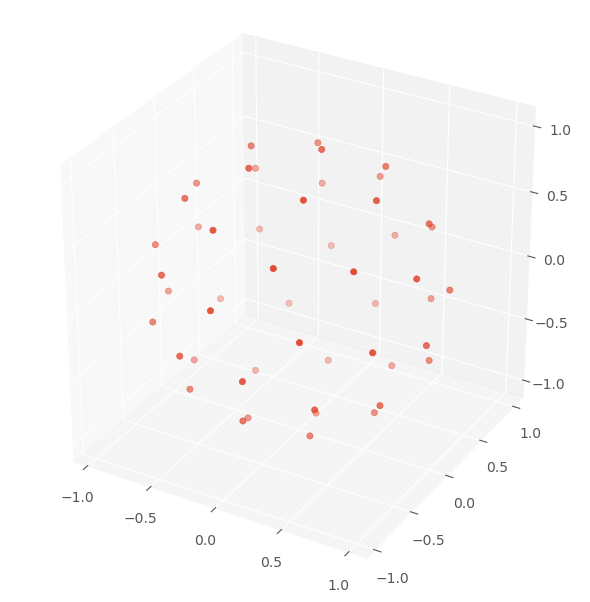

In [27]:
print(compute_radii(out))
plot_sensors(out)